<a href="https://colab.research.google.com/github/Gogi0121/-Final-Year-Project-Yogesh-Yadav/blob/main/01_EDA_Complete_Fake_News_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Part 1: Exploratory Data Analysis (EDA)

# Fake News Detection Using Transformer-Based Deep Learning
## Comparative Study: BERT, RoBERTa & DistilBERT vs Traditional ML

---
**This notebook contains: Data loading + EDA (class distribution, length, n-grams, word clouds).**


## Step 1: Imports

In [1]:
# Install (run once): pip install transformers datasets scikit-learn pandas numpy matplotlib seaborn shap torch wordcloud scipy statsmodels

import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import re
from collections import Counter

from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (accuracy_score, classification_report, confusion_matrix,
                             precision_recall_fscore_support, roc_curve, auc, precision_recall_curve, average_precision_score)

# scipy.stats does NOT provide mcnemar; use statsmodels instead
from statsmodels.stats.contingency_tables import mcnemar

from datasets import Dataset, DatasetDict
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
torch.manual_seed(RANDOM_STATE)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(RANDOM_STATE)

try:
    plt.style.use('seaborn-v0_8-whitegrid')
except:
    plt.style.use('ggplot')

print(f"PyTorch: {torch.__version__}")
print(f"Device: {torch.cuda.get_device_name(0) if torch.cuda.is_available() else 'CPU'}")

PyTorch: 2.9.0+cu126
Device: Tesla T4


## Step 2: Load Dataset (DO NOT MODIFY)

In [2]:
url_fake = "https://raw.githubusercontent.com/laxmimerit/fake-real-news-dataset/main/data/Fake.csv"
url_true = "https://raw.githubusercontent.com/laxmimerit/fake-real-news-dataset/main/data/True.csv"

print("Downloading and Reconstructing Dataset...")

df_fake = pd.read_csv(url_fake)
df_true = pd.read_csv(url_true)
df_fake['label'] = 1
df_true['label'] = 0

df_combined = pd.concat([df_fake, df_true], axis=0).sample(frac=1, random_state=42).reset_index(drop=True)
df_combined['text'] = df_combined['title'] + " " + df_combined['text']
df_combined = df_combined[['text', 'label']]

print(f"✓ Dataset: {len(df_combined)} samples")

train_df, test_df = train_test_split(df_combined, test_size=0.2, random_state=42, stratify=df_combined['label'])
ds = DatasetDict({'train': Dataset.from_pandas(train_df), 'test': Dataset.from_pandas(test_df)})

print(f"Train: {len(ds['train'])}, Test: {len(ds['test'])}")

✓ Dataset: 44898 samples
Train: 35918, Test: 8980


## Step 3: Exploratory Data Analysis (EDA)

/tmp/ipython-input-369627752.py:4: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels(['Real', 'Fake'])


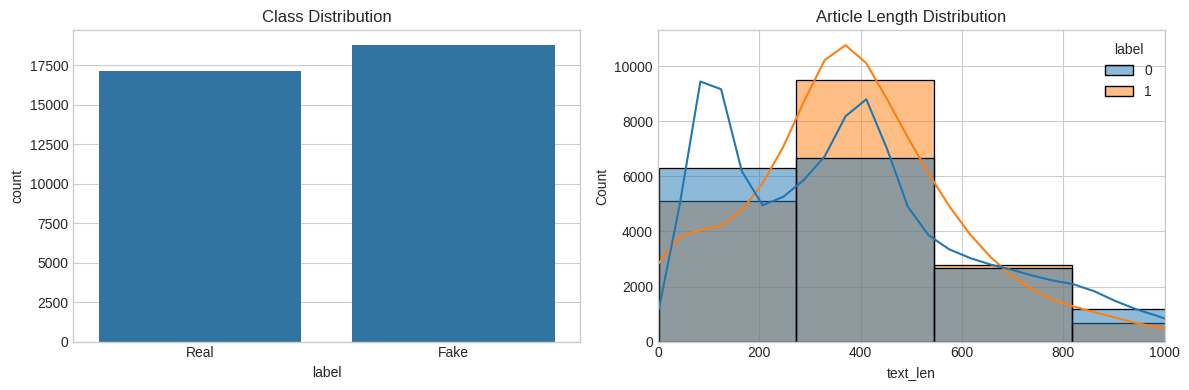

In [3]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
sns.countplot(x=train_df['label'], ax=axes[0])
axes[0].set_title('Class Distribution')
axes[0].set_xticklabels(['Real', 'Fake'])

train_df['text_len'] = train_df['text'].apply(lambda x: len(str(x).split()))
sns.histplot(data=train_df, x='text_len', hue='label', kde=True, bins=30, ax=axes[1])
axes[1].set_title('Article Length Distribution')
axes[1].set_xlim(0, 1000)
plt.tight_layout()
plt.show()

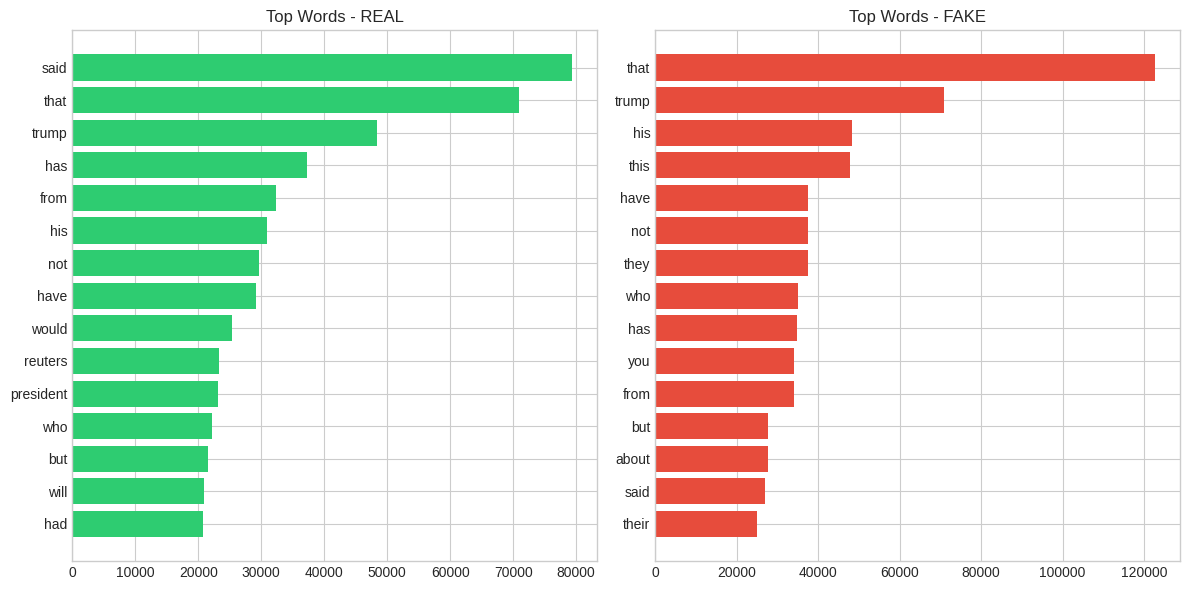

In [4]:
def get_top_ngrams(texts, n=1, top_n=15):
    words = []
    stop = {'the','a','an','is','are','was','were','to','of','in','for','on','with','at','by','and','or'}
    for t in texts:
        tokens = re.findall(r'\b[a-zA-Z]+\b', str(t).lower())
        tokens = [w for w in tokens if w not in stop and len(w)>2]
        if n==2: tokens = [f"{tokens[i]} {tokens[i+1]}" for i in range(len(tokens)-1)]
        words.extend(tokens)
    return Counter(words).most_common(top_n)

real_txt = [t for t,l in zip(train_df['text'], train_df['label']) if l==0]
fake_txt = [t for t,l in zip(train_df['text'], train_df['label']) if l==1]

top_r, top_f = get_top_ngrams(real_txt), get_top_ngrams(fake_txt)
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
w_r, c_r = zip(*top_r) if top_r else ([], [])
w_f, c_f = zip(*top_f) if top_f else ([], [])
ax[0].barh(range(len(w_r)), c_r, color='#2ecc71')
ax[0].set_yticks(range(len(w_r)))
ax[0].set_yticklabels(w_r)
ax[0].set_title('Top Words - REAL')
ax[0].invert_yaxis()
ax[1].barh(range(len(w_f)), c_f, color='#e74c3c')
ax[1].set_yticks(range(len(w_f)))
ax[1].set_yticklabels(w_f)
ax[1].set_title('Top Words - FAKE')
ax[1].invert_yaxis()
plt.tight_layout()
plt.show()

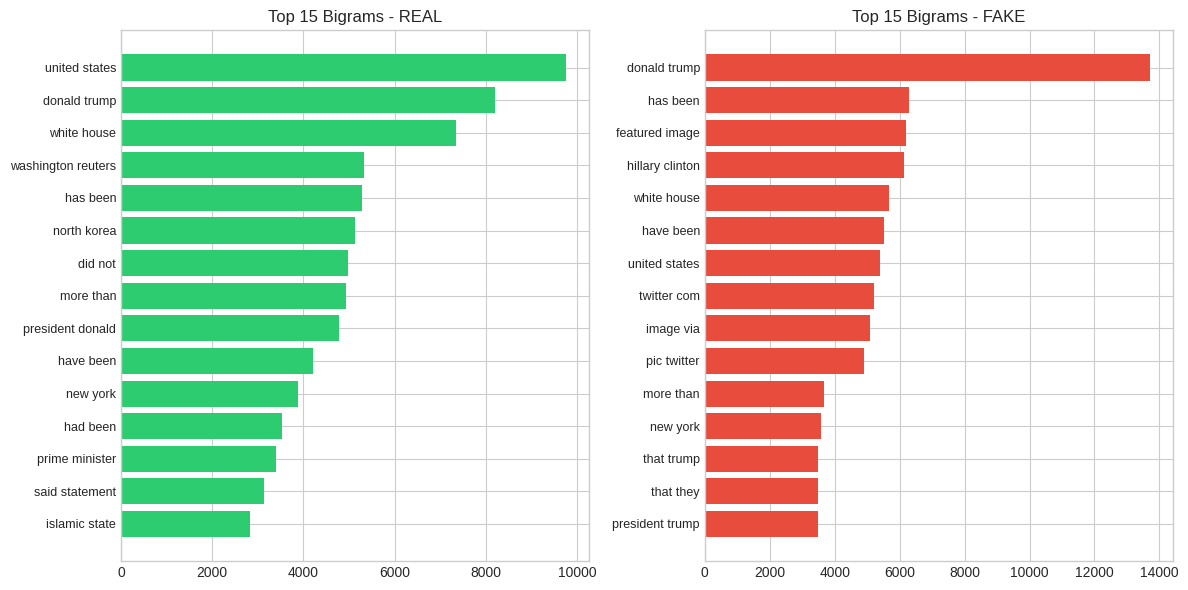

In [5]:
# Bigram visualization (RQ3 support)
top_r_bg, top_f_bg = get_top_ngrams(real_txt, n=2, top_n=15), get_top_ngrams(fake_txt, n=2, top_n=15)
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
w_r, c_r = zip(*top_r_bg) if top_r_bg else ([], [])
w_f, c_f = zip(*top_f_bg) if top_f_bg else ([], [])
ax[0].barh(range(len(w_r)), c_r, color='#2ecc71')
ax[0].set_yticks(range(len(w_r)))
ax[0].set_yticklabels(w_r, fontsize=9)
ax[0].set_title('Top 15 Bigrams - REAL')
ax[0].invert_yaxis()
ax[1].barh(range(len(w_f)), c_f, color='#e74c3c')
ax[1].set_yticks(range(len(w_f)))
ax[1].set_yticklabels(w_f, fontsize=9)
ax[1].set_title('Top 15 Bigrams - FAKE')
ax[1].invert_yaxis()
plt.tight_layout()
plt.show()

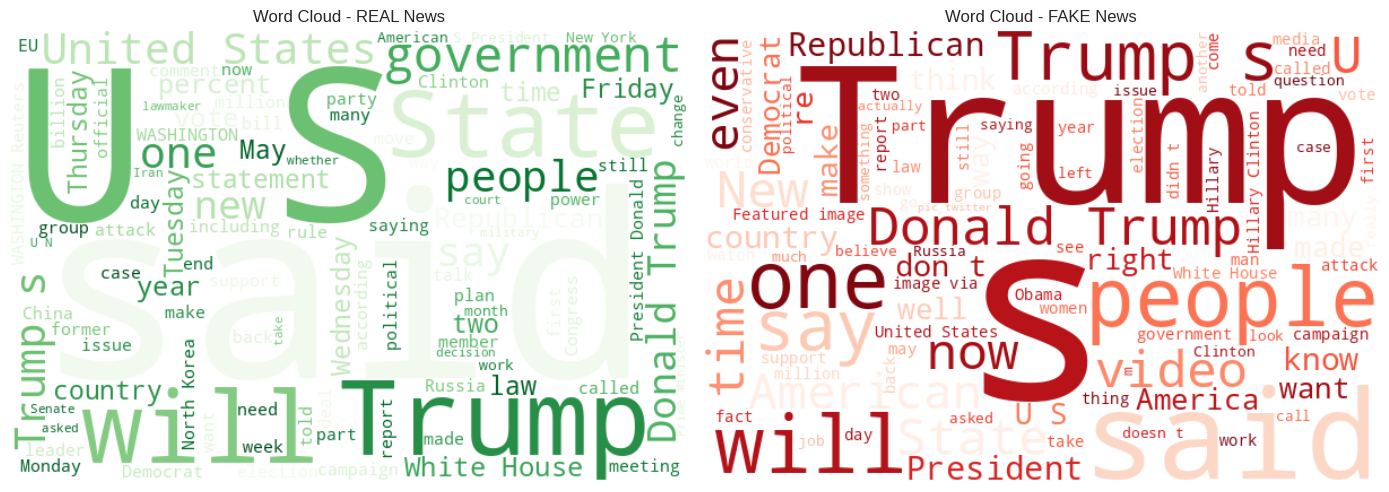

In [6]:
# Word Cloud: Real vs Fake News (RQ3 support)
from wordcloud import WordCloud

text_real = ' '.join(str(t) for t in real_txt[:2000])
text_fake = ' '.join(str(t) for t in fake_txt[:2000])
wc_real = WordCloud(width=600, height=400, background_color='white', colormap='Greens', max_words=100).generate(text_real)
wc_fake = WordCloud(width=600, height=400, background_color='white', colormap='Reds', max_words=100).generate(text_fake)

fig, ax = plt.subplots(1, 2, figsize=(14, 6))
ax[0].imshow(wc_real, interpolation='bilinear')
ax[0].set_title('Word Cloud - REAL News')
ax[0].axis('off')
ax[1].imshow(wc_fake, interpolation='bilinear')
ax[1].set_title('Word Cloud - FAKE News')
ax[1].axis('off')
plt.tight_layout()
plt.show()